# 05 — Hedging Portfolio with VIX Futures

In this notebook we investigate how to hedge exposure to equities using the VIX. We use an ETF that has very high correlation to the volatility index as a proxy investment, and use the S&P 500 index as a proxy for SPX (since they have near-identical returns due to the high liquidity). We first conduct:

- **Exploratory analysis:** Provide rigorous evidence for hedging ability of the VIX/VXX

- **Hedging:** Compute the Minimum Variance Portfolio (MVP) by computing $\beta^{*}$ and building an optimal statically hedged portfolio.

- **Dynamic Hedging:** We test a real-time trading strategy over this period using dynamic hedging.

- **Evaluation:** Analyze performance and validate theoretical results from Portfolio theory.

- **Conclusions:** Summary and Interpretation


## VIX Futures Short Term ETF

Exposure to the VIX index is in general hard to achieve for investers. It can be achieved through VIX options, futures (provided by CBOE) or ETFs that track VIX futures. We use a short term ETF that tracks the **S&P 500 VIX Short-Term Futures index** called **iPath Series B S&P 500 VIX Short-Term Futures ETN (VXX)**. This is inappropriate for long-term hedged positions i.e. buy-and-hold portfolios.

The fund tracks an index with exposure to futures contracts on the CBOE Volatility Index with average one-month maturity and exposure resets daily.

VXX was launched on Jan 19, 2018 and is issued by iPath.

One reason for this choice is the ease of data collection for this particular ETF (we can scrape Yahoo Finance).

**ETF Flow Analysis Report**:

"It’s important to note that VXX does not represent a spot investment in the VIX, but rather is linked to an index comprised of VIX futures. As such, the performance of this product will often vary significantly from a hypothetical investment in the VIX (which isn’t possible to establish). The focus on short-dated futures increases the correlation to the VIX, but also increases the potential for the adverse impacts of contango. Longer-dated options such as VIIZ, VIXM, or VXZ may be appropriate for longer holding period."

"One structural note: as an ETN, VXX avoids tracking error but may expose investors to credit risk, as well as unique tax treatments. VIXY offers similar exposure in an ETF wrapper, while VIIX is a near-identical ETN alternative."

References:
- https://www.cboe.com/tradable-products/vix/vix-futures
- https://ipathetn.cib.barclays/details.app;instrumentId=341408
- https://www.marketbeat.com/stocks/BATS/VXX/
- https://etfdb.com/etf/VXX/#etf-ticker-profile


## Pre-processing

Loading the required libraries, raw data and initial pre-processing:
- Compute returns (pct changes)
- Drop "NaN" entries
- Allign data on trading days
- Combine into one dataframe
- Save data into `data/processed` as `returns_ytd_spx_vix_vxx.csv`

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from pathlib import Path
plt.style.use("seaborn-v0_8-whitegrid")

**Data reads**

In [2]:
pd.set_option("display.max_columns", None)

# Set paths
DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
DATA_PROCESSED = Path("../data/processed")

# VIX (index)
vix_df = pd.read_csv(DATA_RAW / "vix_ytd_ohlc.csv", parse_dates=["Date"]).sort_values("Date")

# S&P 500
spx_df = pd.read_csv(DATA_RAW / "sp500_ytd_ohlcv.csv", parse_dates=["Date"]).sort_values("Date")

# VXX (proxy for tradable VIX exposure)
vxx_df = pd.read_csv(DATA_RAW / "vxx_ytd_ohlcv.csv", parse_dates=["Date"]).sort_values("Date")

**Data pre-processing**

In [3]:
# Compute daily simple returns
# VIX: use Close (index, non-tradable)
vix = vix_df[["Date", "Close"]].rename(columns={"Close": "VIX_Close"}).copy()
vix["dVIX"] = vix["VIX_Close"].pct_change()

# SPX: use Adj Close (includes dividend and other adjustments)
spx = spx_df[["Date", "Adj Close"]].rename(columns={"Adj Close": "SPX_AdjClose"}).copy()
spx["dSPX"] = spx["SPX_AdjClose"].pct_change()

# VXX: tradable proxy for VIX exposure (ETN built from VIX futures)
vxx = vxx_df[["Date", "Adj Close"]].rename(columns={"Adj Close": "VXX_AdjClose"}).copy()
vxx["dVXX"] = vxx["VXX_AdjClose"].pct_change()

We drop the first trading day since we can't act on that day (it's used for returns the next day).

In [4]:
# Align by trading date (inner join keeps only overlapping dates)
ret = (
    vix.merge(spx, on="Date", how="inner")
       .merge(vxx, on="Date", how="inner")
       .sort_values("Date")
       .reset_index(drop=True)
)

# drop first row where pct_change() is NaN
ret = ret.dropna(subset=["dVIX", "dSPX", "dVXX"]).reset_index(drop=True)

display(ret.head(3))
print(f"Aligned rows: {len(ret)} (from {ret['Date'].min().date()} to {ret['Date'].max().date()})")

,Date,VIX_Close,dVIX,SPX_AdjClose,dSPX,VXX_AdjClose,dVXX
0,2025-01-03,16.13,-0.100390,5942.47,0.012596,44.10,-0.058497
1,2025-01-06,16.04,-0.005580,5975.38,0.005538,43.90,-0.004535
2,2025-01-07,17.82,0.110973,5909.03,-0.011104,46.41,0.057175


Aligned rows: 212 (from 2025-01-03 to 2025-11-06)


We then have 212 trading days.

**Save data**

save code is commented out.

In [5]:
DATA_PROCESSED = Path("../data/processed")
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

out_path = DATA_PROCESSED / "returns_ytd_spx_vix_vxx.csv"
# ret.to_csv(out_path, index=False)
# print("Saved:", out_path)

## Exploratory analysis

We analyze the relationships between the three instruments and compute

- The correlation matrix between daily returns with entries $c_{ij} = corr(r_i,r_j)$

- The 30-day rolling correlation between daily returns

- Regression between SPX/VIX and SPX/VXX (as before)

- VIX tracking with our Futures ETF VXX

**Correlation Matrix**

This computes the raw relationship in our datasets.

ERROR! Session/line number was not unique in database. History logging moved to new session 112


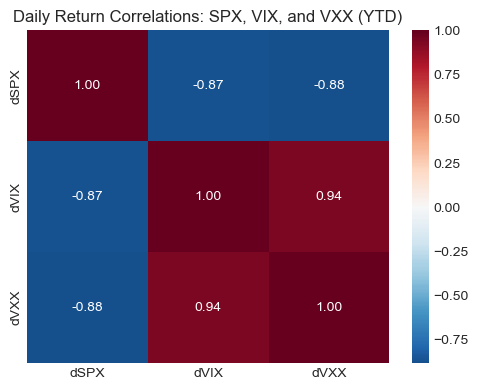

Saved CSV: ..\reports\tables\corr_matrix.csv


In [16]:
# Static correlations (daily returns)
corr = ret[["dSPX", "dVIX", "dVXX"]].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Daily Return Correlations: SPX, VIX, and VXX (YTD)")
plt.tight_layout()
plt.show()

corr

out_dir = Path("../reports/tables")
os.makedirs(out_dir, exist_ok=True)

# round for readability
corr_rounded = corr.round(3)

# save as CSV
csv_path = out_dir / "corr_matrix.csv"
corr_rounded.to_csv(csv_path)
print(f"Saved CSV: {csv_path}")

**Rolling Correlation**

This shows the time-varying senstitvity of SPX/VIX and SPX/VXX - which will motivate dynamic hedging later on.

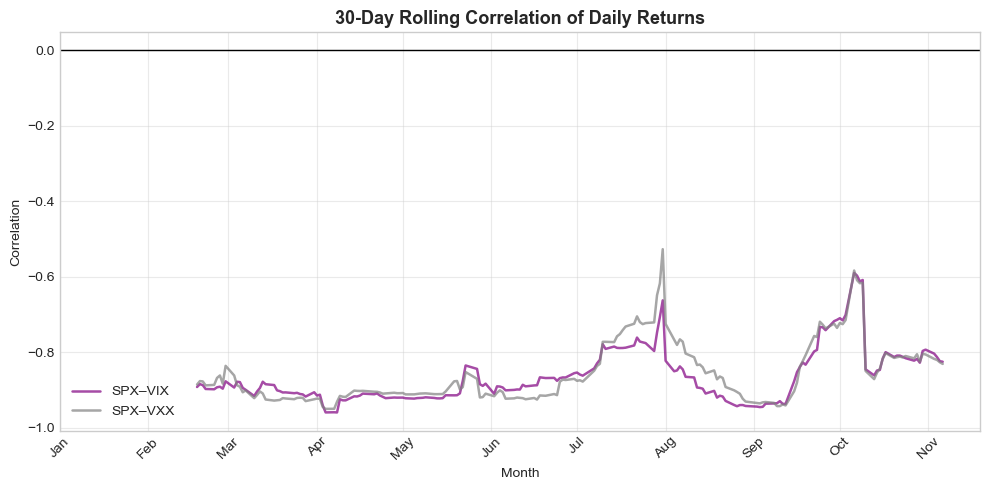

In [18]:
# Rolling 30-day correlation between SPX and VIX/VXX
window = 30
ret["roll_corr_spx_vix"] = ret["dSPX"].rolling(window).corr(ret["dVIX"])
ret["roll_corr_spx_vxx"] = ret["dSPX"].rolling(window).corr(ret["dVXX"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(ret["Date"], ret["roll_corr_spx_vix"],
        label="SPX–VIX", color="purple", alpha=0.7, lw=1.8)
ax.plot(ret["Date"], ret["roll_corr_spx_vxx"],
        label="SPX–VXX", color="gray", alpha=0.7, lw=1.8)

ax.axhline(0, color="black", lw=1)
ax.set_title(f"{window}-Day Rolling Correlation of Daily Returns", fontsize=13, weight="bold")
ax.set_ylabel("Correlation")
ax.set_xlabel("Month")

# Month tick labels (Jan, Feb, ...)
year = ret["Date"].min().year
month_ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_ticks.strftime("%b"), rotation=45)

ax.legend(frameon=False, loc="lower left")
ax.grid(alpha=0.4)
plt.tight_layout()
# save rolling correlation plot
plt.savefig("../reports/figures/rolling_corr.png", dpi=300, bbox_inches="tight")
plt.show()

Clearly there are some term-rate costs and our tracking of the SPX/VIX relationship using SPX/VXX is not perfect - but as we will see, it is quite good!

**Sensitivity and Regression Analysis**

Computing $\beta$ and the Regression Model using `statsmodels`

In [21]:
# OLS: dVIX = α + β * dSPX
X = sm.add_constant(ret["dSPX"])
model_vix = sm.OLS(ret["dVIX"], X).fit()

# OLS: dVXX = α + β * dSPX
model_vxx = sm.OLS(ret["dVXX"], X).fit()

print("=== Regression: SPX vs VIX ===")
print(model_vix.summary().tables[1])
print("\n=== Regression: SPX vs VXX ===")
print(model_vxx.summary().tables[1])

=== Regression: SPX vs VIX ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.834      0.005       0.003       0.015
dSPX          -6.3183      0.250    -25.289      0.000      -6.811      -5.826

=== Regression: SPX vs VXX ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.400      0.163      -0.001       0.005
dSPX          -3.4080      0.126    -27.040      0.000      -3.656      -3.160


**Plotting Model**

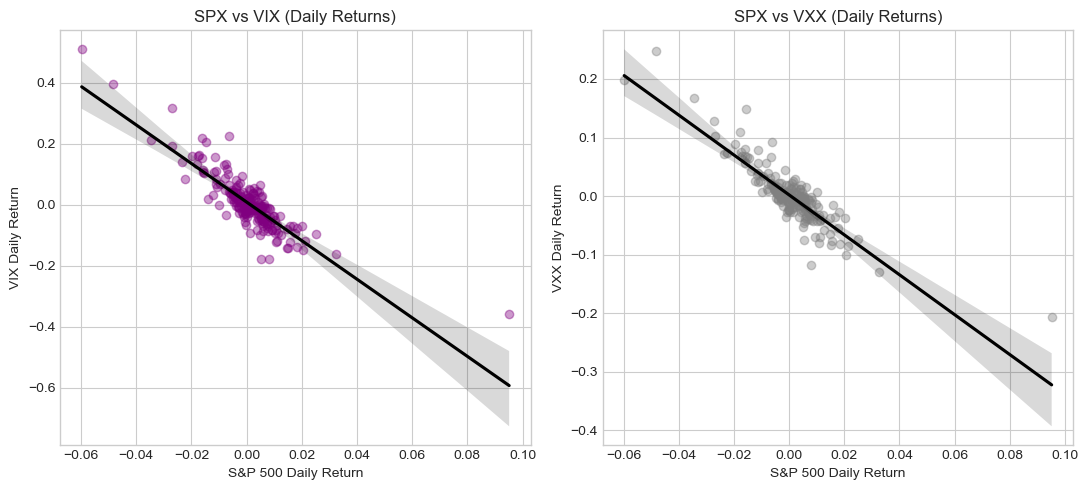

In [22]:
# Scatter with best-fit lines for visual intuition
fig, axes = plt.subplots(1, 2, figsize=(11,5), sharey=False)

sns.regplot(x="dSPX", y="dVIX", data=ret, ax=axes[0],
            scatter_kws=dict(alpha=0.4, color="purple"), line_kws=dict(color="black"))
axes[0].set_title("SPX vs VIX (Daily Returns)")
axes[0].set_xlabel("S&P 500 Daily Return")
axes[0].set_ylabel("VIX Daily Return")

sns.regplot(x="dSPX", y="dVXX", data=ret, ax=axes[1],
            scatter_kws=dict(alpha=0.4, color="gray"), line_kws=dict(color="black"))
axes[1].set_title("SPX vs VXX (Daily Returns)")
axes[1].set_xlabel("S&P 500 Daily Return")
axes[1].set_ylabel("VXX Daily Return")

plt.tight_layout()
# save scatter regression plot
# plt.savefig("../reports/figures/scatter_spx_vix_vxx.png", dpi=300, bbox_inches="tight")
plt.show()

Very similar relationship is observed (as in our previous notebook).

This section provided indirect evidence for using our Futures ETF VXX as an instrument to gain exposure to the VIX since the relationships to SPX are near identical. The direct correlation between VIX and VXX was $0.94$ - which means we achieve sufficiently good tracking of the VIX. We can also visualize this more clearly on our YTD data.

**VIX tracking with VXX**

We plot the normalized values of the index and the ETF prices.

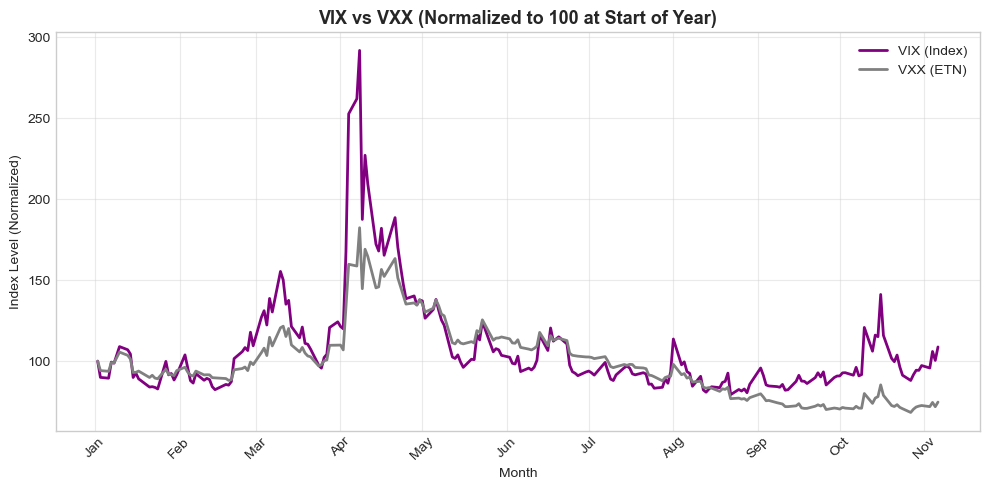

In [23]:
# normalize both to 100 at start for visual comparison
merged = (
    vix_df[["Date", "Close"]].rename(columns={"Close": "VIX_Close"})
    .merge(vxx_df[["Date", "Adj Close"]].rename(columns={"Adj Close": "VXX_AdjClose"}), on="Date", how="inner")
    .sort_values("Date")
)
merged["VIX_norm"] = 100 * merged["VIX_Close"] / merged["VIX_Close"].iloc[0]
merged["VXX_norm"] = 100 * merged["VXX_AdjClose"] / merged["VXX_AdjClose"].iloc[0]

# plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(merged["Date"], merged["VIX_norm"], color="purple", lw=2, label="VIX (Index)")
ax.plot(merged["Date"], merged["VXX_norm"], color="gray", lw=2, label="VXX (ETN)")

# month ticks
year = merged["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=merged["Date"].max(), freq="MS")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

ax.set_title("VIX vs VXX (Normalized to 100 at Start of Year)", fontsize=13, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Index Level (Normalized)")
ax.legend(frameon=False, loc="best")
ax.grid(alpha=0.4)
plt.tight_layout()
# plt.savefig("../reports/figures/vix_vxx_tracking.png", dpi=300, bbox_inches="tight")
plt.show()

The normalized values being equal is in fact not what we require for exposure (since this depends on nominal wealth and we are concerend with proportions) - what we do require is that *the instruments move together* i.e. a high correlation, which we already computed to be about 0.94, and this can also be observed visuallly.

> VXX roughly follows VIX spikes but decays faster over calm periods — also illustrating futures roll yield / negative carry effects.

## Static Hedging

We compute the Minimum Variance Portfolio P comprised of:
- SPX (B) = Benchmark placeholder for M, the Market holdings
- VXX = the VIX Futures ETF

The portfolio returns are given by

$$R_P = R_{SPX} + \beta \times R_{VXX}$$

and the optimal weight $\beta^{*}$ (optimal hedge ratio) is given by

$$ \beta^{*} =  - \frac{Cov(R_{SPX},R_{VXX} )}{Var(R_{VXX})} $$


In [24]:
# Compute covariance, variance and optimal weight w*
cov_spx_vxx = np.cov(ret["dSPX"], ret["dVXX"], ddof=1)[0,1]
var_vxx     = np.var(ret["dVXX"], ddof=1)
w_star = -cov_spx_vxx / var_vxx

print(f"Static variance-minimizing weight on VXX (w*): {w_star:.3f}")

# Build portfolio returns for SPX only, SPX + w*·VXX, and a milder hedge 0.5·w*
ret["port_spx_only"] = ret["dSPX"]
ret["port_static"]   = ret["dSPX"] + w_star * ret["dVXX"]

# Milder hedge: half the optimal weight for comparison
ret["port_static_half"] = ret["dSPX"] + 0.5*w_star * ret["dVXX"]

# Cum returns
def cumret(x): 
    return (1 + x).cumprod() - 1

cum = pd.DataFrame({
    "Date": ret["Date"],
    "SPX": cumret(ret["port_spx_only"]),
    "SPX + w*·VXX": cumret(ret["port_static"]),
    "SPX + 0.5w*·VXX": cumret(ret["port_static_half"])
})

print("\nCumulative returns at end date:")
cum.tail(1)

Static variance-minimizing weight on VXX (w*): 0.228

Cumulative returns at end date:


,Date,SPX,SPX + w*·VXX,SPX + 0.5w*·VXX
211,2025-11-06,0.145141,0.14594,0.149192


Thus, the final returns over this period are as follows:

> SPX: $14.51 \%$

> SPX+VXX optimal: $14.59 \%$

> SPX+VXX milder hedge: $14.91 \%$\

which are comparable, and in fact the differences are also expected using hedging principles (generally the optimal hedge should do better, and a milder hedge increases returns since we eliminate less risk)!

**Performance of Hedging Portfolio**

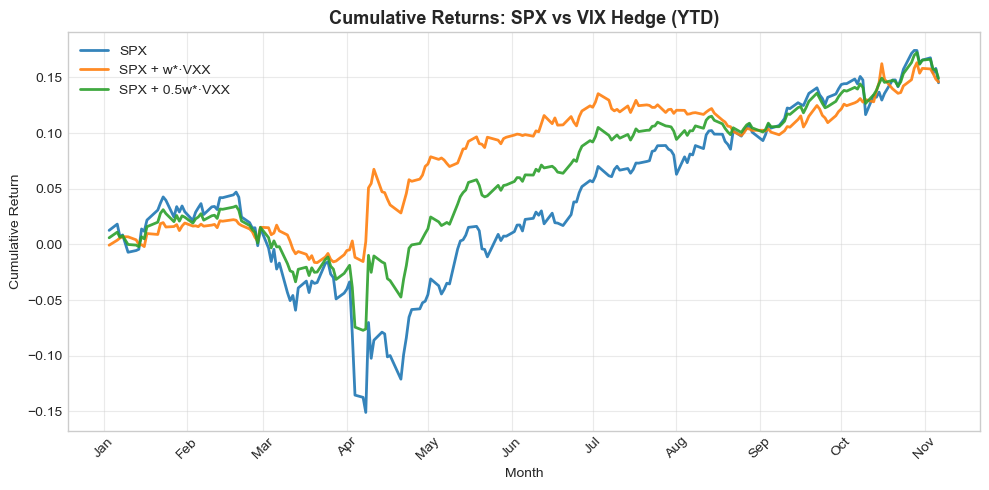

In [25]:
os.makedirs("../reports/figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cum["Date"], cum["SPX"],               label="SPX",              lw=2, alpha=0.9)
ax.plot(cum["Date"], cum["SPX + w*·VXX"],      label="SPX + w*·VXX",     lw=2, alpha=0.9)
ax.plot(cum["Date"], cum["SPX + 0.5w*·VXX"],   label="SPX + 0.5w*·VXX",  lw=2, alpha=0.9)

year = ret["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

ax.set_title("Cumulative Returns: SPX vs VIX Hedge (YTD)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4); ax.legend(frameon=False, loc="best")
plt.tight_layout()
# plt.savefig("../reports/figures/hedge_cum_returns_static.png", dpi=300, bbox_inches="tight")
plt.show()

These results are very promising and consistent with the predictions of Portfolio theory!

> The hedged portfolio tracks the underlying asset SPX very well.

> In calm periods, the hedge slightly underperforms SPX (due to the risk premium).

> In downturns, the hedge performs very well, in fact even providing short-term upside value - this is due to the asymmetry in the VIX: bear markets are more volatile than bull markets.

> The hedge strongly resists large downturns in SPX.

> In bullish markets, the hedge also outperforms the index and by the largest margin (again due to the higher volatility and bull market, both of our positions are improving).

> The milder hedge blunts all these effects.

Let's demonstrate these results rigorously.

**Basic Performance Metrics**

We report the following basic trading metrics:

- **Annualized volatility**: The annualized risk of our portfolio in the traditional sense of varaiance.

$$ \sigma_{\text{annualized}} = \sigma_{\text{daily}} \times \sqrt{\text{trading days}} $$

- **Sharpe ratio**: The sharpe ratio measures how much return is achieved per unit of risk (volatility) in the portfolio. The utiliity maximisation portfolio maximises Sharpe Ratio in modern Portfolio theory.

$$ \text{SR}_p =  \frac{\mathbb{E}(R_p - R_f)}{{\sigma}_p} $$

where we set the risk-free rate $R_f = 0$ for simplicity

- **Maximum Drawdown**: The maximum drawdown measures the largest observed loss from a portfolio’s peak to its subsequent trough before a new peak is reached. It quantifies the worst cumulative decline an investor would have experienced during the period; it's always 0 or negative. Thus, it is a measure of downside risk.

$$
\text{MaxDD} = \min_{t} 
\left(
\frac{V_t - \max_{s \le t} V_s}{\max_{s \le t} V_s}
\right)
$$

where:  
- $V_t$ = portfolio (or cumulative return) value at time $t$  
- $\max_{s \le t} V_s$ = the running maximum of $V$ up to time $t$
- A MaxDD of $-0.25$ (−25%) means the portfolio fell 25% from its highest value before recovering.




Note that we report the annualied Sharpe Ratio (SR) and the Maximum Drawdown is reported as a percentage decline from peak (i.e. loss).



In [ ]:
# Summary metrics for portfolios
def ann_vol(daily_ret, trading_days=252):
    return daily_ret.std(ddof=1) * np.sqrt(trading_days)

def sharpe(daily_ret, rf=0.0, trading_days=252):
    ex = daily_ret - rf/252
    s = ex.mean() / ex.std(ddof=1)
    return s * np.sqrt(trading_days)

def max_drawdown(cum_series):
    peaks = cum_series.cummax()
    dd = (cum_series - peaks) / peaks.replace(0, np.nan)
    return dd.min()

metrics = []
for name, series in {
    "SPX": ret["port_spx_only"],
    "SPX + w*·VXX": ret["port_static"],
    "SPX + 0.5w*·VXX": ret["port_static_half"]
}.items():
    m = {
        "Portfolio": name,
        "Ann.Vol": ann_vol(series),
        "Sharpe(0%)": sharpe(series),
        "MaxDD": max_drawdown((1+series).cumprod())
    }
    metrics.append(m)
    
# format table
metrics_df = (
    pd.DataFrame(metrics)
    .set_index("Portfolio")
    .round({"Ann.Vol (%)": 2, "Sharpe Ratio": 2, "Max Drawdown (%)": 2})
)
display(metrics_df)

# Save code
# out_dir = Path("../reports/tables")
# os.makedirs(out_dir, exist_ok=True)
# out_path = out_dir / "hedge_summary_metrics.csv"
# metrics_df.to_csv(out_path)
# print(f"Saved summary metrics table to: {out_path}")

,Ann.Vol,Sharpe(0%),MaxDD
Portfolio,,,
SPX,0.197557,0.913232,-0.189022
SPX + w*·VXX,0.093319,1.781749,-0.037786
SPX + 0.5w*·VXX,0.127626,1.358207,-0.107918


## Dynamic Hedging (Trading Strategy)

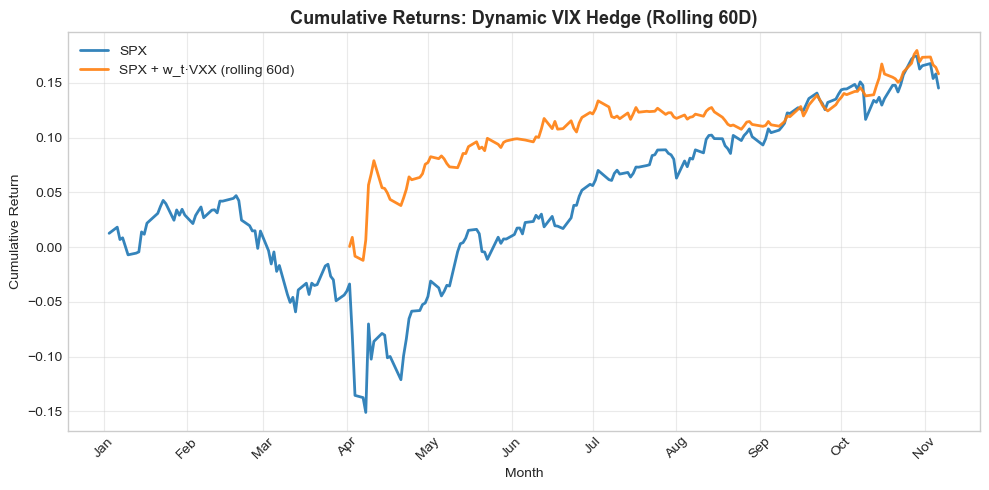

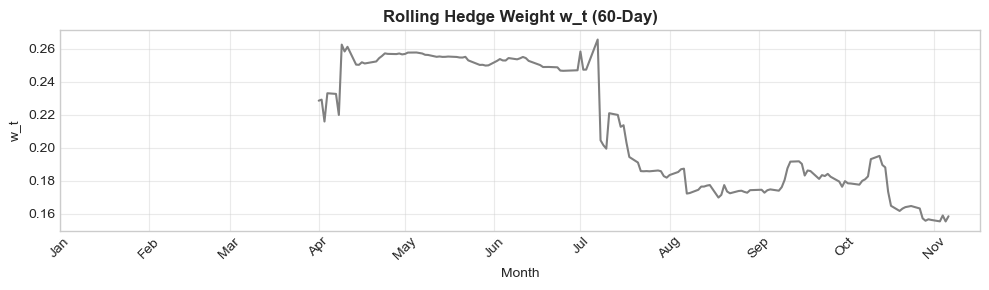

In [28]:
# Rolling hedge ratio (60-day) via covariance formula
win = 60
roll_cov = ret["dSPX"].rolling(win).cov(ret["dVXX"])
roll_var = ret["dVXX"].rolling(win).var()
ret["w_dyn"] = (-roll_cov / roll_var).clip(-10, 10)  # clip extremes for stability

# Dynamic hedged portfolio (lag weight by 1 day to avoid look-ahead bias)
ret["w_dyn_lag"] = ret["w_dyn"].shift(1)
ret["port_dynamic"] = ret["dSPX"] + ret["w_dyn_lag"]*ret["dVXX"]

cum_dyn = (1 + ret[["port_spx_only","port_dynamic"]]).cumprod() - 1

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ret["Date"], cum_dyn["port_spx_only"], label="SPX", lw=2, alpha=0.9)
ax.plot(ret["Date"], cum_dyn["port_dynamic"],  label="SPX + w_t·VXX (rolling 60d)", lw=2, alpha=0.9)

ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)
ax.set_title("Cumulative Returns: Dynamic VIX Hedge (Rolling 60D)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4); ax.legend(frameon=False, loc="best")
plt.tight_layout()
# plt.savefig("../reports/figures/hedge_cum_returns_dynamic.png", dpi=300, bbox_inches="tight")
plt.show()

# Visualize the rolling weight
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(ret["Date"], ret["w_dyn"], color="gray", lw=1.5)
ax.set_title("Rolling Hedge Weight w_t (60-Day)", fontsize=12, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("w_t")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)
ax.grid(alpha=0.4)
plt.tight_layout()
# plt.savefig("../reports/figures/hedge_weight_dynamic.png", dpi=300, bbox_inches="tight")
plt.show()


Reporting the same metrics as before.

In [ ]:
metrics_dyn = []
for name, series in {
    "SPX": ret["port_spx_only"],
    "SPX + w_t·VXX (60d)": ret["port_dynamic"].dropna()
}.items():
    s = series.dropna()
    metrics_dyn.append({
        "Portfolio": name,
        "Ann.Vol": ann_vol(s),
        "Sharpe(0%)": sharpe(s),
        "MaxDD": max_drawdown((1 + s).cumprod())
    })

# Convert to DataFrame
df_dyn = pd.DataFrame(metrics_dyn).set_index("Portfolio")

# Save
os.makedirs("../reports/tables", exist_ok=True)
out_path = "../reports/tables/hedge_dynamic_metrics.csv"
# df_dyn.to_csv(out_path, float_format="%.12f")
print(f"Saved dynamic hedge metrics table to {out_path}")

# Display a rounded version for easy reading
df_dyn.round(3)


Saved dynamic hedge metrics table to ../reports/tables/hedge_dynamic_metrics.csv


,Ann.Vol,Sharpe(0%),MaxDD
Portfolio,,,
SPX,0.198,0.913,-0.189
SPX + w_t·VXX (60d),0.104,2.394,-0.038


> Comparable risk-metrics but much larger Share Ratio

> Signalling that dynamic hedging is worth it

> Regardless, we can ONLY dynamically hedge in practice (since the entire data is not available apriori to compute optimal weight)

> In fact, in practice, we can only rebalance at discrete time steps, but this can be used to approximate the optimal running dynamic hedge weight function (which was displayed above)

> Hedging/rebalancing frequency may also be limited due to convenience, liquidity issues or frictions (e.g. transaction fees) for VIX-based products

## Event Week Analysis

We report the performance as cumulative returns during the weeks of volatility spikes (approximately weeks of downturns) which were highlighted in the Event Study.

In [ ]:
# Event-week comparison: SPX vs hedged around key spike dates
ev = pd.read_csv("../data/interim/vix_spike_annotations.csv", parse_dates=["Date"])
ev = ev[ev["Event"].astype(str).str.strip() != ""].copy()

window = 3  # ±3 trading days around event
rows = []
for d in ev["Date"]:
    if d < ret["Date"].min() or d > ret["Date"].max():
        continue
    # slice ±window days by index
    idx = ret.index[ret["Date"] == d]
    if len(idx)==0: 
        continue
    i = idx[0]
    lo = max(0, i-window); hi = min(len(ret)-1, i+window)
    sl = ret.iloc[lo:hi+1]

    rows.append({
        "EventDate": d.date(),
        "SPX_cum_%": ((1+sl["port_spx_only"]).prod()-1)*100,
        "Static_cum_%": ((1+sl["port_static"]).prod()-1)*100,
        "Dynamic_cum_%": ((1+sl["port_dynamic"].dropna()).prod()-1)*100 if not sl["port_dynamic"].dropna().empty else np.nan
    })


event_compare_df = pd.DataFrame(rows)

# Make sure the tables folder exists
os.makedirs("../reports/tables", exist_ok=True)

# Save CSV
out_path = "../reports/tables/event_week_comparison.csv"
# event_compare_df.to_csv(out_path, index=False, float_format="%.12f")
print(f"Saved event-week comparison table to {out_path}")

# Display
event_compare_df.round(2)

Saved event-week comparison table to ../reports/tables/event_week_comparison.csv


,EventDate,SPX_cum_%,Static_cum_%,Dynamic_cum_%
0,2025-03-10,-4.44,-1.70,NaN
1,2025-04-02,-11.08,0.03,-1.21
2,2025-04-08,-5.42,7.27,7.83
3,2025-08-01,-0.70,-0.11,-0.23
4,2025-10-10,-1.03,1.61,1.07
5,2025-10-16,2.79,0.68,1.37


Plotting highlighted event week regions for clearer interpretation

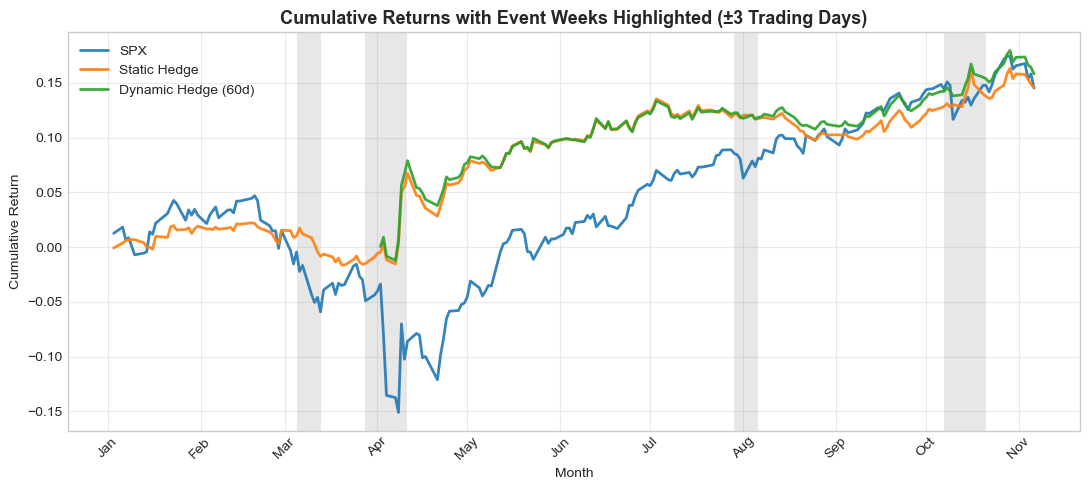

In [36]:
# load annotated events
ev = pd.read_csv("../data/interim/vix_spike_annotations.csv", parse_dates=["Date"])
ev = ev[ev["Event"].astype(str).str.strip() != ""].copy()
ev = ev.sort_values("Date").drop_duplicates(subset=["Date"])

# build ±window-day intervals around each event
window = 3  # trading days on each side
idx_map = {d: i for i, d in enumerate(ret["Date"])}
intervals = []
for _, r in ev.iterrows():
    d = r["Date"]
    if d not in idx_map:
        prev = ret.loc[ret["Date"] <= d, "Date"].max()
        if pd.isna(prev):
            continue
        d = prev
    i = idx_map[d]
    lo = max(0, i - window)
    hi = min(len(ret) - 1, i + window)
    intervals.append([ret["Date"].iloc[lo], ret["Date"].iloc[hi]])

# merge overlapping intervals
intervals = sorted(intervals, key=lambda x: x[0])
merged = []
for start, end in intervals:
    if not merged or start > merged[-1][1]:
        merged.append([start, end])
    else:
        merged[-1][1] = max(merged[-1][1], end)

# plot cumulative returns with shaded event windows
os.makedirs("../reports/figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(cum["Date"], cum["SPX"],               label="SPX",              lw=2, alpha=0.9)
if "SPX + w*·VXX" in cum.columns:
    ax.plot(cum["Date"], cum["SPX + w*·VXX"],  label="Static Hedge",     lw=2, alpha=0.9)
if "port_dynamic" in ret.columns:
    ax.plot(ret["Date"], (1+ret["port_dynamic"]).cumprod()-1, 
            label="Dynamic Hedge (60d)", lw=2, alpha=0.9)

# shaded event windows
for start, end in merged:
    ax.axvspan(start, end, color="tab:gray", alpha=0.18, lw=0)

# monthly x-axis
year = ret["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

ax.set_title("Cumulative Returns with Event Weeks Highlighted (±3 Trading Days)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4)
ax.legend(frameon=False, loc="best")

plt.tight_layout()
plt.savefig("../reports/figures/hedge_event_weeks.png", dpi=300, bbox_inches="tight")
plt.show()

Topics for further investigations:
- Longer time horizons for hedging analysis
- Different rolling windows/parameters etc.
- Simulating VIX using stochastic models
- VIX vs Realized Volatility
- Relationship between VIX and Implied Volatility
- Pricing Options/Futures on the VIX